


<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

## Data : Memorial Sloan Kettering Cancer Center (MSKCC) 


### Real World Problem 

<h3 >A malignant tumour can contain hundreds of genomic alterations after being sequenced. But the difficulty is separating the neutral mutations from the drivers, or those that lead to tumour development (passengers).
The method used up until now was manual, which requires a lot of time and work. </h3>

# 1. Objective
<p> <h3>Based on the ID (name) and variant that each gene carries, we may classify each gene into one of nine categories, some of which are related to cancerous tumours.</h3>

1. Molecular pathologist select a genetic variation to analyze(consider genetic variation as a catogrical random variable).
2. Pathologist Searches for evidence in medical literature that are relevant to genetic variation he picked
3. Analyzing each text literature corresponding to particular genes(this process is time consuming)
<h3>our work is to automate step 3 with a machine learning model</h3>.</p>

## Problem Statement
## Task: Develop algorithms for classifying genetic mutations based on clinical data (text). Predict the class in which there was a genetic mutation.

<h2> Real-world/Business objectives and constraints.</h2>

* No requirements for low latency.
* The ability to interpret is extremely important.
* Mistakes may be quite expensive.
* The likelihood that a data point belongs to each class is required.

<h1>2. Machine Learning Problem Formulation</h1>

<h3> Data </h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
-Description of files:
#### training_variants - contains a description of the genetic mutations used for training.
-Fields: ID - string identifier that is used to associate the mutation with clinical data,
-Gene - the gene in which this genetic mutation is located, 
-Variation - amino acid change for this mutation, 
-Class - 1-9 class in which this genetic mutation was classified
#### training_text- is a double-pipe (||) delimited file containing clinical data (text) used to classify genetic mutations. 
-Fields: ID - identifier of the string used to associate clinical data with a genetic mutation.
-Text - clinical data used to classify a genetic mutation)
#### test_variants - contains a description of the genetic mutations used for training. 
-ID - string identifier that is used to associate the mutation with clinical data
-Gene - the gene in which this genetic mutation is located, 
-Variation - amino acid change for this mutation
#### test_text is a double pipe delimited file (||) containing clinical data (text) used to classify genetic mutations.
-Fields: ID - identifier of the string used to associate clinical data with a genetic mutation, 
-Text - clinical data used to classify a genetic mutation)
-<p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3>Type of Machine Learning Problem</h3>

<p>
     Genetic mutations can be categorised into nine separate classes. => Multi class classification Problem.
    
</p>

<h3>Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


## 2.1 Loading Data:

<p> A csv file containing the features is created and stored.
This notebook's dataframe contains the generated csv file.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
import string
from nltk.corpus import stopwords
import nltk
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12,6)

In [2]:
data_variant = pd.read_csv('training_variants')
data_variant.sample(7)

,ID,Gene,Variation,Class
2307,2307,JAK1,V658F,7
3148,3148,KRAS,P34R,7
2395,2395,NF1,Y489C,4
531,531,TP53,G266E,1
472,472,TP53,A347T,1
364,364,EPAS1,P531S,2
2882,2882,BRCA2,D2723G,1


In [3]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
data_text.sample(7)

,ID,TEXT
164,164,Oncogenic mutations in the epidermal growth fa...
2281,2281,Oligodendroglioma is characterized by unique c...
1813,1813,Mutational hotspots indicate selective pressur...
1660,1660,Mutations in the juxtamembrane and kinase doma...
3024,3024,The pathogenesis of most gastrointestinal stro...
1976,1976,We screened 75 primary hepatocellular carcinom...
373,373,Genotoxic stress triggers a rapid translocatio...


## 3. Familiarizing with Data
#### In this step, few dataframe methods are used to look into the data and its features.

In [4]:
print('Number of data points : ', data_variant.shape[0])
print('Number of features : ', data_variant.shape[1])
print('Features : ', data_variant.columns.values)
print(data_variant.shape)

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']
(3321, 4)


In [5]:
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
print(data_text.shape)

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']
(3321, 2)


## 3.1. Text Data Preprocessing
##### We have a tonne of textual information. Therefore, we must preprocess it. Therefore, let's create a function for it.

- reference https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing/notebook

In [6]:
counter = 0
with open("training_text",encoding="utf8") as infile:
    while True:
        counter += 1
        line = infile.readline()
        print(line)
        if counter==2:
            break

ID,Text

0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

<h4>Predicting the class of the mutation given the content in the literature is the main task at hand. Then, we'll try different NLP methods to turn the free text into features for an ML classifier to evaluate which ones perform the best.</h4>

In [7]:
# loading stop words from nltk library
    
def preprocessing_text(text):
    PUNCT_TO_REMOVE = string.punctuation
    STOPWORDS = set(stopwords.words('english'))
    
   # Convert text to lowercase
    text = text.lower()
    
    #Remove punctuation characters, we don't need them
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    
   #Remove stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    # replace every special char with space
    text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
    # replace multiple spaces with single space
    text = re.sub('\s+',' ', text)
    
    
    #Remove rare words
    cnt = Counter()
    n_rare_words = 10
    RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
    text = " ".join([word for word in str(text).split() if word not in RAREWORDS])
    
    #Stemming - convert words to base form

    #stemmer = PorterStemmer()
    #text = " ".join([stemmer.stem(word) for word in text.split()])
    
    #Lemmatization - similar to stemming, but guaranteeing that the word belongs to this language is slower
    #lemmatizer = WordNetLemmatizer()
    return text

In [8]:
#data_text['clean_text']=data_text.TEXT.apply(lambda x: preprocessing_text(x))
start_time = time.process_time()
for ind, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        preprocessing_text(row['TEXT'])
    else:
        print("Id that doesn't have a text description.:",ind)
        
        
print('Duration of text preprocessing :',time.process_time() - start_time, "seconds")

Id that doesn't have a text description.: 1109
Id that doesn't have a text description.: 1277
Id that doesn't have a text description.: 1407
Id that doesn't have a text description.: 1639
Id that doesn't have a text description.: 2755
Duration of text preprocessing : 67.171875 seconds


In [9]:
preprocessing_text(data_text.TEXT[0])[:100]

'cyclindependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last o'

In [10]:
df_train = pd.merge(data_variant, data_text, how = 'left', on = 'ID').fillna('')
df_train.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
df_train.shape

(3321, 5)

In [12]:
#Full Information Of Dataset
float_cols = df_train.select_dtypes('float64').columns
for c in float_cols:
    df_train[c] = df_train[c].astype('float32')
    
int_cols = df_train.select_dtypes('int64').columns
for c in int_cols:
    df_train[c] = df_train[c].astype('int32')
    
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int32 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int32 
 4   TEXT       3321 non-null   object
dtypes: int32(2), object(3)
memory usage: 129.7+ KB


In [13]:
%%time
df_train['clean_text'] = df_train.TEXT.apply(lambda x: preprocessing_text(x))

CPU times: total: 1min 4s
Wall time: 1min 5s


In [14]:
### Function for counting a word in a text, can be used as an additional feature generation

def count_words(TEXT, Gene_Var):
    wordlist = TEXT.split(' ')
    cnt = 0
    for s in wordlist:
        if (Gene_Var==s):
            cnt+=1
    return cnt

In [15]:
#replacing Null values
df_train.loc[df_train['TEXT'].isnull(),'TEXT'] = df_train['Gene'] +' '+df_train['Variation']

In [16]:
#again checking for null values
df_train[df_train.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT,clean_text


##### We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [17]:
final_df =df_train.drop(['TEXT'], axis=1)
final_df.sample(10)

,ID,Gene,Variation,Class,clean_text
607,607,SMAD4,D357Y,4,introduction transforming growth factor tgf pl...
2068,2068,TET2,D1384V,6,tet proteins oxidize 5methylcytosine 5mc dna p...
653,653,CDKN2A,T77P,4,abstract germline mutations cdkn2a gene found ...
2023,2023,MAP2K1,E203K,7,mapkerk pathway ras raf mek erk pathway one ex...
313,313,ELF3,Truncating Mutations,1,previous studies shown promoter type ii tgf re...
3175,3175,RAB35,A151T,7,shrna screen genes affect akt phosphorylation ...
645,645,CDKN2A,G67R,4,inherited mutations affecting ink4aarf locus c...
2657,2657,BRCA1,S1715N,4,abstract brca1 gene individuals risk breast ov...
3015,3015,KIT,N564_Y578del,2,57yearold man gastrointestinal stromal tumor g...
651,651,CDKN2A,D84H,4,abstract tumor suppressor p16ink4a eight nterm...


In [18]:
y_true = final_df['Class'].values
final_df.Gene      = final_df.Gene.str.replace('\s+', '_')
final_df.Variation = final_df.Variation.str.replace('\s+', '_')

C:\Users\reetu raj harsh\AppData\Local\Temp\ipykernel_8304\2083544810.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  final_df.Gene      = final_df.Gene.str.replace('\s+', '_')
C:\Users\reetu raj harsh\AppData\Local\Temp\ipykernel_8304\2083544810.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  final_df.Variation = final_df.Variation.str.replace('\s+', '_')


In [19]:
final_df.head()

,ID,Gene,Variation,Class,clean_text
0,0,FAM58A,Truncating_Mutations,1,cyclindependent kinases cdks regulate variety ...
1,1,CBL,W802*,2,abstract background nonsmall cell lung cancer ...
2,2,CBL,Q249E,2,abstract background nonsmall cell lung cancer ...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas blineage...


#### Splitting data into train, test and cross validation (64:20:16)

In [20]:
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit, KFold

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(df_train, y_true, stratify=y_true, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [21]:
train_df.shape

(2124, 6)

In [22]:
test_df.shape

(665, 6)

In [23]:
cv_df.shape

(532, 6)

## 3.2 Distribution of class in diffrent dataset

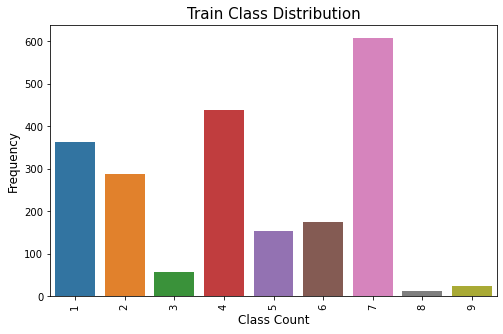

In [24]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
plt.figure(figsize=(8,5))
sns.countplot(x="Class", data=train_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Train Class Distribution", fontsize=15)
plt.show()

In [25]:
sorted_train = np.argsort(-train_class_distribution.values)
for i in sorted_train:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i],
          '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


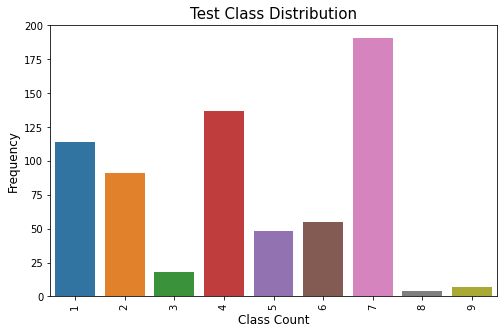

In [26]:
test_class_distribution = test_df['Class'].value_counts().sort_index()
plt.figure(figsize=(8,5))
sns.countplot(x="Class", data=test_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Test Class Distribution", fontsize=15)
plt.show()

In [27]:
sorted_test = np.argsort(-test_class_distribution.values)
for i in sorted_test:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i],
          '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


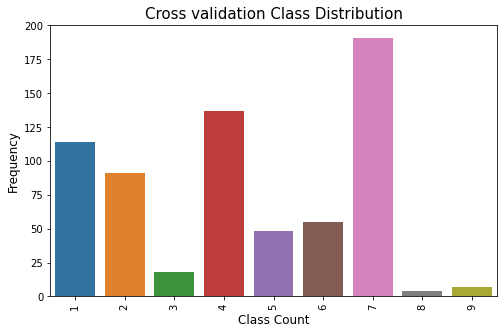

In [28]:
cv_class_distribution = cv_df['Class'].value_counts().sort_index()
plt.figure(figsize=(8,5))
sns.countplot(x="Class", data=test_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Cross validation Class Distribution", fontsize=15)
plt.show()

In [29]:
sorted_cv = np.argsort(-train_class_distribution.values)
for i in sorted_cv:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i],
          '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


### 4. Random Model Generation

##### The idea behind random model is to create a reference error value (True - Generated), based on randomly generated value This reference error gives a sense of how well our build model performce against the randomly generated values

#### How we construct random model for our multiclassification case:

- Generate series filled with random probabilities
- Probabilities a distribute randomly across classes (1-9)
- Log_loss is used to measure the accuracy ( Submission requires log loss )

<p>
We shall create 9 random integers from 1 to 9 to represent the 9 output classes for this application. To indicate the probability for each class, we will add these nine values and divide them by the total. we will select the highest probability value, draw a confusion matrix, and compute the total log-loss.
    
The idea behind random model is to create a reference error value (True - Generated), based on randomly generated value This reference error gives a sense of how well our build model performce against the randomly generated values

How we construct random model for our multiclassification case:

Generate series filled with random probabilities
Probabilities a distribute randomly across classes (1-9)
Log_loss is used to measure the accuracy ( Submission requires log loss )

We begin by defining a function for visualising the confusion matrix:
The purpose of the random model is to generate a reference error value (True - Generated), which measures how well our built model performs in comparison to the randomly generated data.

How we build a random model in our multiclassification example

Create a series with random probabilities in it.
Probabilities are randomly distributed throughout the classes (1-9)
Accuracy is measured by log loss ( Submission requires log loss )</p>

In [30]:
from sklearn.metrics import log_loss
test_data_len = test_df.shape[0]
cv_len = cv_df.shape[0]

#we establish an output array that has precisely same size as the CV data
cv_predicted_y = np.zeros((cv_len,9))
for i in range(cv_len):
    random_prob = np.random.rand(1,9)
    cv_predicted_y[i] = ((random_prob/random_prob.sum())[0])

cv_log_loss = round(log_loss(y_cv,cv_predicted_y, eps=1e-15),2)

print("Log loss on Cross Validation Data using Random Model",cv_log_loss)


test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    random_prob = np.random.rand(1,9)
    test_predicted_y[i] = ((random_prob/random_prob.sum())[0])
test_log_loss = round(log_loss(y_test,test_predicted_y, eps=1e-15),2)

print("Log loss on Test Data using Random Model",test_log_loss)

Log loss on Cross Validation Data using Random Model 2.5
Log loss on Test Data using Random Model 2.52


It appears that 2.5 will serve as our main basis. Our model performs poorly the closer its log loss is approaching 2.5!

The following matrices will be used to assess the performance of random and subsequently actual ML models:

- Confusion Matrix
In plain language, the confusion matrix is used to gauge how accurately our model classifies input.
Diagonally organised cells will have a stronger correlation if models are successful.
- Recall Matrix
In layman's terms, it refers to a model's capacity to locate all the relevant data points in a dataset.
True Positive / (True Positive + False Negative) in mathematics
- Precision Matrix
In layman's terms, precision identifies the percentage of data items that the model qualifies as relevant as being relevant
In mathematics, the formula is True Positive / (True Positive + False Positive).

In [31]:
predicted_y =np.argmax(test_predicted_y, axis=1)
# Because class values range from 0 to 8. Additionally, there are numbers 1 through 9. The n+1 formula will convert it to 1–9.
predicted_y = predicted_y+1

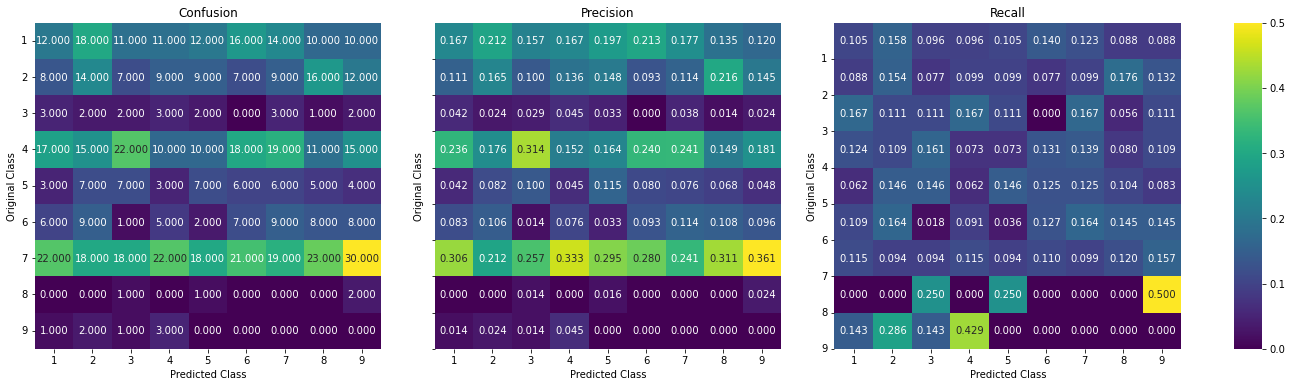

In [32]:
from sklearn.metrics import confusion_matrix

def plot_matrices(y_test,predicted_y):  

    confusion = confusion_matrix(y_test, predicted_y)
    precision =(confusion/confusion.sum(axis=0))
    recall =(((confusion.T)/(confusion.sum(axis=1))).T)
    
    f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, 
                gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="viridis", fmt=".3f", xticklabels=labels, yticklabels=labels,)
    g1.set_ylabel('Original Class')
    g1.set_xlabel('Predicted Class')
    g1.set_title('Confusion')
    g2 = sns.heatmap(precision,cmap="viridis",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
    g2.set_ylabel('Original Class')
    g2.set_xlabel('Predicted Class')
    g2.set_yticks(labels)
    g2.set_title('Precision')
    g3 = sns.heatmap(recall,cmap="viridis",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    g3.set_ylabel('Original Class')
    g3.set_xlabel('Predicted Class')
    g3.set_title('Recall')
    g3.set_yticks(labels)
    
    for ax in [g1,g2,g3]:
        tl = ax.get_xticklabels()
        ax.set_xticklabels(tl, rotation=0)
        tly = ax.get_yticklabels()
        ax.set_yticklabels(tly, rotation=0)
    
    plt.show()

plot_matrices(y_test,predicted_y)

<p>
In the present confusion matrix, three data points for class 1 correspond to the original and anticipated classes. There are 8 data points in class 2 that fit both the original and anticipated classes, and so on. As a result, utilising the confusion matrix provides a more accurate representation of the model's performance than simply looking at a single number of log loss. As you are aware, the model is regarded to be optimally adjusted if all diagonal values are high.</p>

 # 5. Feature Evaluation

## Define Evaluating Functions:
 - Evaluation Model:
- Stochastic Gradient Descent classifier
- Logistic Regression (sigmoid)
- Calibrated Classifier - Post Processing the model to improve probability estimates
- Use onehotCoding
- Penalty='l2'
- Below are the functions that will help us with evaluating our features

### 5.1Gene column evaluation
- Examine the word distribution.
- String data must be transformed to numeric data before the ML technique can be used.
- Encoding Method: One-hot Encoding

In [33]:
train_df.Gene.unique()

array(['FGFR2', 'KIT', 'CCND1', 'ERBB2', 'NRAS', 'PTCH1', 'MET', 'MAP2K2',
       'BRCA1', 'ERCC4', 'JAK1', 'EGFR', 'CBL', 'ERBB4', 'PIK3CA',
       'BRCA2', 'BRD4', 'SRC', 'CDKN2A', 'CARD11', 'RAC1', 'PDGFRB',
       'ALK', 'KDM5A', 'RHOA', 'BCL2', 'SF3B1', 'ARID2', 'MYCN', 'RAF1',
       'PTEN', 'POLE', 'PIK3R1', 'MSH6', 'PTPN11', 'TP53', 'MTOR', 'FLT3',
       'TSC2', 'ROS1', 'KMT2B', 'NTRK1', 'ESR1', 'STK11', 'AKT1', 'BRAF',
       'H3F3A', 'NF2', 'DNMT3A', 'BAP1', 'ELF3', 'ERG', 'EPAS1', 'RET',
       'SMAD4', 'PIK3CB', 'KRAS', 'EP300', 'RAD54L', 'FGFR3', 'PIK3R3',
       'SOX9', 'ETV6', 'FBXW7', 'NFKBIA', 'HRAS', 'SMO', 'CEBPA', 'AKT2',
       'RAD50', 'CDH1', 'VHL', 'MYC', 'SMAD2', 'FANCA', 'FGFR4', 'FAT1',
       'RUNX1', 'PTPRT', 'TGFBR1', 'NOTCH1', 'RHEB', 'ABL1', 'SOS1',
       'HNF1A', 'CDKN2B', 'EWSR1', 'DICER1', 'AR', 'TP53BP1', 'KDM5C',
       'JAK2', 'PMS2', 'CTNNB1', 'TET2', 'KDR', 'MSH2', 'PDGFRA',
       'NKX2-1', 'FGF3', 'SMARCA4', 'KNSTRN', 'AXIN1', 'JUN', 'RAD51C'

In [34]:
genecount =train_df['Gene'].value_counts()
genecount

BRCA1      163
TP53       105
BRCA2       88
EGFR        84
PTEN        76
          ... 
HLA-A        1
MAP3K1       1
KMT2B        1
RAD51D       1
BCL2L11      1
Name: Gene, Length: 240, dtype: int64

In [35]:
genecount.shape

(240,)

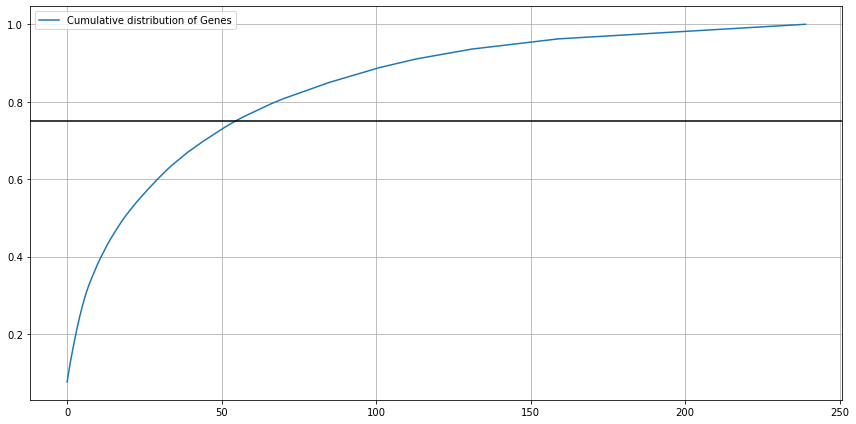

In [36]:
total_unique_values = sum(genecount.values);
percent_per_total = genecount.values/total_unique_values;
cumulative = np.cumsum(percent_per_total)
plt.plot(cumulative,label='Cumulative distribution of Genes',)

plt.grid()
plt.axhline(0.75, color='k')
plt.legend()
plt.tight_layout()
plt.show()


###### Looks like 75% of data consists of approximately 50 most common words.

In [37]:
# Gene' featureVectorizing 
from sklearn.feature_extraction.text import CountVectorizer

g_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding =  g_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding  =  g_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding    =  g_vectorizer.transform(cv_df['Gene'])

##### Evaluating Functions Definition:
- Testing Framework:
- Gradient Stochastic Classifier for descent
- Calibrated Logistic Regression (sigmoid) Classifier - Post-processing the model to enhance probability estimations
- Penalty='l2' for onehotCoding
- The functions listed below will assist us in assessing our features.

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

def alpha_loss(alpha,train_feat_hotencode,cv_feat_hotencode):
    """
    Input: Hyperparameter Alpha, Train_Feature_onehotencoded, CV_Feature_onehotencoded
    Output: Hyperparameter Tunning DataFrame 
    """
    cv_log_error_array=[]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
        clf.fit(train_feat_hotencode, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    
    # 
        sig_clf.fit(train_feat_hotencode, y_train)
        predict_y = sig_clf.predict_proba(cv_feat_hotencode)
    
        cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

    temp_df = pd.DataFrame(data={'alpha': np.round(alpha,5), 
                                 'cv_log_loss': np.round(cv_log_error_array,5)})
    return temp_df

In [39]:
def all_set(name,best_alpha,
                 train_feat_hotencode,
                 cv_feat_hotencode,
                 test_feat_hotencode):
    '''
    Input: Feature name, Best Alpha, and All 3 OneHotEncoded Sets 
    Output: Log-Loss Report data frame
    '''
    # Model
    clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', random_state=42)
    clf.fit(train_feat_hotencode, y_train)
    sigmoid_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sigmoid_clf.fit(train_feat_hotencode, y_train)
    
    train_predict_y = sigmoid_clf.predict_proba(train_feat_hotencode)
    train_log_loss = np.round(log_loss(y_train, train_predict_y, labels=clf.classes_, eps=1e-15),3)

    cv_predict_y = sigmoid_clf.predict_proba(cv_feat_hotencode)
    cv_log_loss = np.round(log_loss(y_cv, cv_predict_y, labels=clf.classes_, eps=1e-15),3)
    
    test_predict_y = sigmoid_clf.predict_proba(test_feat_hotencode)
    test_log_loss = np.round(log_loss(y_test, test_predict_y, labels=clf.classes_, eps=1e-15),3)
    
    report_log_loss=[name,
                     best_alpha,
                     train_log_loss,
                     cv_log_loss,
                     test_log_loss]
    
    temp_df = pd.DataFrame([report_log_loss],columns=['Feature','best alpha','train_log_loss','cv_log_loss','test_log_loss' ])   
    return temp_df

In [40]:
test_train_cover=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_train_cover=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
test_train_olap = np.round(test_train_cover*100/test_df.shape[0],1)
cv_train_olap =  np.round(cv_train_cover*100/cv_df.shape[0],1)


olap= pd.DataFrame(data=[[test_train_olap,cv_train_olap]],columns=['Test-Train Data Overlap[%]','CV-Train Data Overlap[%]'])

# Evaluating Gene Feature
alpha = [10 ** x for x in range(-5, 1)]
# Tunning Hyper Parameter (Alpha)
tunning_df = alpha_loss(alpha,train_gene_feature_onehotCoding,cv_gene_feature_onehotCoding)
# Selecting Best Alpha
best_alpha = tunning_df.loc[tunning_df['cv_log_loss'] == tunning_df['cv_log_loss'].min(), 'alpha'].item()

# Calculating Log_Loss for all test sets
gene_feat = all_set('Gene',best_alpha,
                         train_gene_feature_onehotCoding,
                         cv_gene_feature_onehotCoding,
                         test_gene_feature_onehotCoding)

# Combining Report
gene_report=pd.concat([gene_feat,olap],axis=1)
gene_report


,Feature,best alpha,train_log_loss,cv_log_loss,test_log_loss,Test-Train Data Overlap[%],CV-Train Data Overlap[%]
0,Gene,0.0001,0.981,1.21,1.197,97.7,97.7


###### Great. Our log loss performed better than our Random Model (2.50). It appears that the lowest error occurs when Alpha = 0.0001.


## 5.2 'Variation' Column Evaluation

In [41]:
train_df.Variation.unique()

array(['P253R', 'Amplification', 'CCND1-IGH Fusion', ..., 'S501_A502dup',
       'G697C', 'S505N'], dtype=object)

In [42]:
varcount =train_df['Variation'].value_counts()
varcount

Truncating Mutations    56
Deletion                52
Amplification           40
Fusions                 21
Overexpression           6
                        ..
C1156F                   1
L181P                    1
P387S                    1
E207K                    1
S505N                    1
Name: Variation, Length: 1925, dtype: int64

In [43]:
varcount.shape

(1925,)

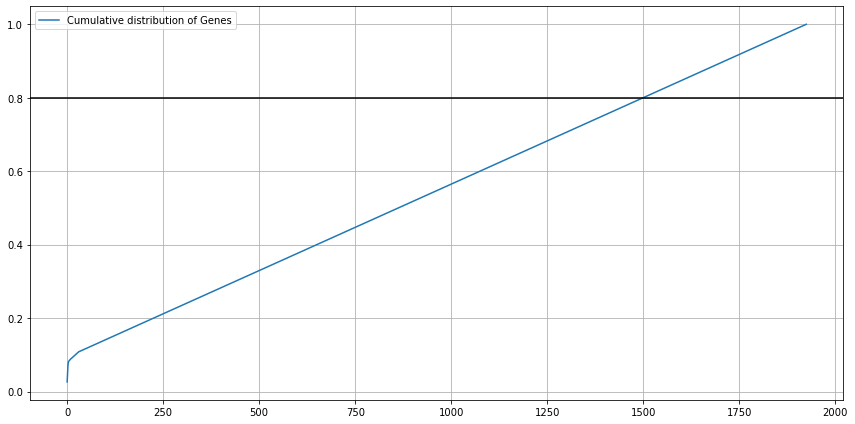

In [44]:
total_unique_values = sum(varcount.values);
percent_per_total = varcount.values/total_unique_values;
cumulative = np.cumsum(percent_per_total)
plt.plot(cumulative,label='Cumulative distribution of Genes',)

plt.grid()
plt.axhline(0.80, color='k')
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
var_vectorizer = CountVectorizer()

train_variation_feature_onehotCoding =  var_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding  =  var_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding    =  var_vectorizer.transform(cv_df['Variation'])

In [46]:
test_train_cover=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_train_cover=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
test_train_ol = np.round(test_train_cover*100/test_df.shape[0],1)
cv_train_ol =  np.round(cv_train_cover*100/cv_df.shape[0],1)

overlapped= pd.DataFrame(data=[[test_train_ol,cv_train_ol]],columns=['Test-Train Data Overlap[%]','CV-Train Data Overlap[%]'])

alpha = [10 ** x for x in range(-5, 1)]

tunning_df = alpha_loss(alpha,train_gene_feature_onehotCoding,cv_gene_feature_onehotCoding)

best_alpha = tunning_df.loc[tunning_df['cv_log_loss'] == tunning_df['cv_log_loss'].min(), 'alpha'].item()


feat_rep = all_set('Variation',best_alpha,
                         train_variation_feature_onehotCoding,
                         cv_variation_feature_onehotCoding,
                         test_variation_feature_onehotCoding)

variation_report=pd.concat([feat_rep,overlapped],axis=1)
variation_report

,Feature,best alpha,train_log_loss,cv_log_loss,test_log_loss,Test-Train Data Overlap[%],CV-Train Data Overlap[%]
0,Variation,0.0001,0.731,1.692,1.687,9.8,10.5


### In compared to the train, the CV and Test log loss is significantly larger. The coverage of variation data is most likely poor. Let's see what happens.

### 5.3Evaluating Text column

In [47]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['clean_text'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 72165


C:\Users\reetu raj harsh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [48]:
# Normalizing One_Hot_Encoding
from sklearn.preprocessing import normalize

# we use the same vectorizer that was trained on train data
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

### Below is code used to find an overal of words between sets

In [49]:
# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
# .A1 turns(compresses) Matrix into Array
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# We will use it to check overlaps between data sets
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

# Sorting dictionary based on the value ( not key ) 
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2
len1,len2 = get_intersec_text(test_df)
test_train_overlap =np.round((len2/len1)*100, 1)
len1,len2 = get_intersec_text(cv_df)
cv_train_overlap = np.round((len2/len1)*100, 1)

In [50]:
overlap= pd.DataFrame(data=[[test_train_overlap, cv_train_overlap]],columns=['Test-Train Data Overlap[%]','CV-Train Data Overlap[%]'])

# Evaluating Gene Feature
alpha = [10 ** x for x in range(-5, 1)]
# Tunning Hyper Parameter (Alpha)
tunning_df = alpha_loss(alpha,train_gene_feature_onehotCoding,cv_gene_feature_onehotCoding)
# Selecting Best Alpha
best_alpha = tunning_df.loc[tunning_df['cv_log_loss'] == tunning_df['cv_log_loss'].min(), 'alpha'].item()

# Calculating Log_Loss for all test sets
feat_rep = all_set('TEXT',best_alpha,
                         train_text_feature_onehotCoding,
                         cv_text_feature_onehotCoding,
                         test_text_feature_onehotCoding)

# Combining Report
text_report=pd.concat([feat_rep,overlap],axis=1)

In [51]:
all_features = pd.concat([gene_report,variation_report,text_report],axis=0)
all_features

,Feature,best alpha,train_log_loss,cv_log_loss,test_log_loss,Test-Train Data Overlap[%],CV-Train Data Overlap[%]
0,Gene,0.0001,0.981,1.210,1.197,97.7,97.7
0,Variation,0.0001,0.731,1.692,1.687,9.8,10.5
0,TEXT,0.0001,0.715,1.209,1.263,90.8,91.7


#### Seems like Variation column can be an issues, since the there is a small overalap between data sets

### 6. Feature Prepation for Machine Learning

### 6.1 Definning Model Evaluation Function

In [52]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)




def eval_alpha_model_loss(alpha,train_feat_hotencode,cv_feat_hotencode):
    """
    IN: Hyperparameter Alpha, Train_Feature_onehotencoded, CV_Feature_onehotencoded
    OUT: Hyperparameter Tunning DataFrame 
    """
    cv_log_error_array=[]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
        clf.fit(train_feat_hotencode, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_feat_hotencode, y_train)
        predict_y = sig_clf.predict_proba(cv_feat_hotencode)
    
        cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

    temp_df = pd.DataFrame(data={'alpha': np.round(alpha,5), 
                                 'cv_log_loss': np.round(cv_log_error_array,5)})
    return temp_df

In [53]:
def plot_matrices(y_test,predicted_y):  

    confusion = confusion_matrix(y_test, predicted_y)
    precision =(confusion/confusion.sum(axis=0))
    recall =(((confusion.T)/(confusion.sum(axis=1))).T)
    
    
    f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, 
                gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
    g1.set_ylabel('Class')
    g1.set_xlabel('Class')
    g1.set_title('Confusion')
    g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
    g2.set_ylabel('Class')
    g2.set_xlabel('Class')
    g2.set_yticks(labels)
    g2.set_title('Precision')
    g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    g3.set_ylabel('Class')
    g3.set_xlabel('Class')
    g3.set_title('Recall')
    g3.set_yticks(labels)
    
    for ax in [g1,g2,g3]:
        tl = ax.get_xticklabels()
        ax.set_xticklabels(tl, rotation=0)
        tly = ax.get_yticklabels()
        ax.set_yticklabels(tly, rotation=0)  
    plt.show()   

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    # calculating the number of data points that are misclassified
    plot_matrices(test_y, pred_y)    

def model_performance(name,clf,best_alpha,
                 train_X_hotencode,
                 cv_X_hotencode,
                 test_X_hotencode):
    '''
    IN: Model name, Classifier, Best Alpha, and All 3 OneHotEncoded Sets 
    OUT: Log-Loss Report data frame
    '''
    # Model
    clf = clf
    clf.fit(train_X_hotencode, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_X_hotencode, train_y)
    
    train_predict_y = sig_clf.predict_proba(train_X_hotencode)
    train_log_loss = np.round(log_loss(y_train, train_predict_y, labels=clf.classes_, eps=1e-15),3)

    cv_predict_y = sig_clf.predict_proba(cv_X_hotencode)
    cv_log_loss = np.round(log_loss(y_cv, cv_predict_y, labels=clf.classes_, eps=1e-15),3)
    
    test_predict_y = sig_clf.predict_proba(test_X_hotencode)
    test_log_loss = np.round(log_loss(y_test, test_predict_y, labels=clf.classes_, eps=1e-15),3)
    
    pred_y = sig_clf.predict(test_X_hotencode)
    
    miss_class = np.count_nonzero((pred_y- test_y))/test_y.shape[0]
    
    
    report_log_loss=[name,
                     best_alpha,
                     train_log_loss,
                     cv_log_loss,
                     test_log_loss,
                     miss_class]
    
    temp_df = pd.DataFrame([report_log_loss],columns=['Model','best alpha','train_log_loss','cv_log_loss','test_log_loss','Miss_classified(%)' ])   
    return temp_df

### 6.2 Feature Stacking
- All three hot encoded features are stacked together

In [54]:
from scipy.sparse import hstack

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

### 6.3 TI_DF

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=5, max_features=16000, strip_accents='unicode', lowercase=True,
    analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english'
)

tfidf_vectorizer.fit(train_df['clean_text'])



TfidfVectorizer(max_features=16000, min_df=5, ngram_range=(1, 3),
                stop_words='english', strip_accents='unicode',
                sublinear_tf=True, token_pattern='\\w+')

In [56]:
X_train_tfidfmatrix = tfidf_vectorizer.transform(train_df ['clean_text'].values)
y_train = train_df['Class'].values

In [57]:
tfidf_vectorizer.fit(test_df['clean_text'])

TfidfVectorizer(max_features=16000, min_df=5, ngram_range=(1, 3),
                stop_words='english', strip_accents='unicode',
                sublinear_tf=True, token_pattern='\\w+')

In [58]:
X_test_tfidfmatrix = tfidf_vectorizer.transform(test_df['clean_text'].values)


# 7 Model Evaluation

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import cross_val_predict



def model(X, y, clf=None):
    prob = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8,shuffle=True), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    predi_indices = np.argmax(prob, axis=1)
    classes = np.unique(y)
    predi = classes[predi_indices]
    print('Log loss: {}'.format(log_loss(y, prob)))
    print('Accuracy: {}'.format(accuracy_score(y, predi)))

## 7.1 Logistic Regression

In [60]:
model(X_train_tfidfmatrix, y_train, clf=LogisticRegression())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Log loss: 1.1514598608529307
Accuracy: 0.6351224105461394


In [61]:
model(train_x_onehotCoding, train_y, clf=LogisticRegression())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Log loss: 1.122440529214119
Accuracy: 0.6581920903954802


## 7.2 Naive Bayes

In [62]:
model(X_train_tfidfmatrix, y_train, clf=MultinomialNB() )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Log loss: 2.0940192708141665
Accuracy: 0.5315442561205274


In [63]:
model(train_x_onehotCoding, train_y, clf=MultinomialNB())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Log loss: 6.825323592674892
Accuracy: 0.6195856873822976
